[Colab Link](https://colab.research.google.com/drive/1LOxoYJRUh1SijdyMOK9lcDeDPlk3brri?usp=sharing)

In [24]:
import torch

from torch import nn
from torch import torch_version
from torch.utils.data import DataLoader

import torchvision

from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Normalize, Compose

import os 

import matplotlib.pyplot as plt
import numpy as np 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Torch version: ', torch.__version__)
print('Torch CUDA avail? ', torch.cuda.is_available())
print(f'Using {device}')

Torch version:  1.11.0+cu113
Torch CUDA avail?  True
Using cuda


In [2]:
# Define func to normalize RGB vals of images
transform = Compose (
    [ToTensor(), 
    Normalize(
        (0.5, 0.5, 0.5), # mean for RGB vals
        (0.5, 0.5, 0.5)  # std dev
    )]
)


In [8]:
# Download and set data

trainingData = CIFAR10 (
    root = 'cifar', 
    train = True, 
    download = True, 
    transform=transform
)

testData = CIFAR10(
    root = 'cifar', 
    train = False, 
    download = True, 
    transform=transform
)


Files already downloaded and verified
Files already downloaded and verified


In [29]:
batchSize = 4

trainingDataLoader = DataLoader(
    trainingData, 
    batch_size=batchSize, 
    shuffle=True
)

testDataLoader = DataLoader(
    testData, 
    batch_size=batchSize, 
    shuffle=True
)

print(trainingDataLoader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [16]:
for x,y in trainingDataLoader:
    print(f'Shape of x [N, C, H, W]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


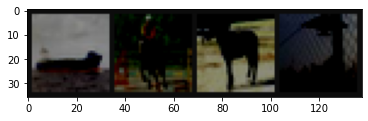

ship  horse horse airplane


In [23]:
# Show and examine data, images in this case

def showImage(img):
    img = img / 2 + 0.05 
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


classes = trainingData.classes 
classes 

data = iter(trainingDataLoader)
images, labels = data.next() 

showImage(make_grid(images))

print(' '.join(f'{classes[labels[i]]:5s}' for i in range(batchSize)))

In [25]:
# All pytorch models inherit from nn.module
class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten() # flattens n-dimensional tensor of images into flat array
        
        # Architecture of model
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024), # Take in flattened tensor of 32x32 imgs with 3 RGB vals
            nn.ReLU(), 
            nn.Linear(1024, 512), # Define these values how you like but the output val of last layer is input val of next layer
            nn.ReLU(), 
            nn.Linear(512, 10) # Last ouput layer is 10 because there are 10 classes of images
        )

    def forward(self, x):
        x = self.flatten(x)

        return self.linear_relu_stack(x)


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [26]:
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [27]:
def train(dataLoader, model, lossFn, optimizer):
    size = len(dataLoader.dataset)

    model.train()

    for batch, (x, y) in enumerate(dataLoader):
        x, y = x.to(device), y.to(device)

        # predict output
        pred = model(x)
        loss = lossFn(pred, y)

        # backprop
        optimizer.zero_grad() # set gradient to 0
        loss.backward() # computes gradient with loss
        optimizer.step() # updates weights 

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f'Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

In [30]:
def test(dataLoader, model, lossFn):
    size = len(dataLoader.dataset)
    numBatches = len(dataLoader)

    model.eval()
    testLoss, correct = 0, 0 

    with torch.no_grad(): # do not calculate gradient since no backprop
        for x, y in dataLoader:
            x, y = x.to(device), y.to(device)

            pred = model(x)

            testLoss += lossFn(pred, y).item() 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # If y == 1, classification correct?

    testLoss /= numBatches
    correct /= size 

    print(f'--- Test Error ---')
    print(f'Accuracy: {(100 * correct):>0.1f}%')
    print(f'Avg Loss: {testLoss:>8f}')


In [32]:
epochs = 10

for i in range(epochs):
    print(f'Epoch {i+1}')

    train(trainingDataLoader, model, lossFn, optimizer)
    test(testDataLoader, model, lossFn)

print('Finished!')

Epoch 1
Loss: 2.095499  [    0/50000]
Loss: 1.535660  [ 4000/50000]
Loss: 2.035324  [ 8000/50000]
Loss: 2.012169  [12000/50000]
Loss: 1.771101  [16000/50000]
Loss: 1.466914  [20000/50000]
Loss: 1.794274  [24000/50000]
Loss: 1.664878  [28000/50000]
Loss: 1.089585  [32000/50000]
Loss: 1.957077  [36000/50000]
Loss: 1.736438  [40000/50000]
Loss: 1.594073  [44000/50000]
Loss: 2.147726  [48000/50000]
--- Test Error ---
Accuracy: 43.3%
Avg Loss: 1.617047
Epoch 2
Loss: 0.850429  [    0/50000]
Loss: 1.779945  [ 4000/50000]
Loss: 1.294135  [ 8000/50000]
Loss: 1.336774  [12000/50000]
Loss: 1.468032  [16000/50000]
Loss: 1.208672  [20000/50000]
Loss: 1.901836  [24000/50000]
Loss: 1.730106  [28000/50000]
Loss: 1.442935  [32000/50000]
Loss: 2.623115  [36000/50000]
Loss: 1.612845  [40000/50000]
Loss: 0.987964  [44000/50000]
Loss: 1.330079  [48000/50000]
--- Test Error ---
Accuracy: 46.6%
Avg Loss: 1.524156
Epoch 3
Loss: 1.314885  [    0/50000]
Loss: 1.204953  [ 4000/50000]
Loss: 1.030762  [ 8000/50000

In [33]:
torch.save(model.state_dict(), 'cifar_fc.pth')

In [34]:
model = NeuralNetwork()
model.load_state_dict(torch.load('cifar_fc.pth'))

<All keys matched successfully>

In [36]:
correctPred = {name: 0 for name in classes}
totalPred = {name: 0 for name in classes}

with torch.no_grad():
    for data in testDataLoader:
        images, labels = data 
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)

        for label, pred in zip(labels, predictions):
            if label == pred:
                correctPred[classes[label]] += 1 
            
            totalPred[classes[label]] += 1 

for name, correct in correctPred.items():
    accuracy = 100 * float(correct) / totalPred[name]
    
    print(f'Accuracy for {name:10s}: {accuracy:.1f}%')


Accuracy for airplane  : 61.4%
Accuracy for automobile: 57.2%
Accuracy for bird      : 38.0%
Accuracy for cat       : 33.4%
Accuracy for deer      : 41.5%
Accuracy for dog       : 45.2%
Accuracy for frog      : 66.5%
Accuracy for horse     : 65.8%
Accuracy for ship      : 69.6%
Accuracy for truck     : 64.6%
